# NYC Taxi homework2

## RQ1 In what period of the year Taxis are used more?
#### Create a plot that, for each month, shows the average number of trips recorded each day. Due to the differences among New York zones, we want to visualize the same information for each boroughs. Do you notice any difference among them? Provide comments and plausible explanations about what you observe (e.g.: what is the month with the highest daily average?)

#### First, we imported all the libraries we will use to answer the question

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from scipy import stats
import folium
import json
%matplotlib inline

##### we started the work by importing all the datasets for each month with Pandas, summed the number of daily trips for each month dividing by the number of days of the month , obtaining the desired average. After this operation we plot the result with seaborn. The first Graph show the average trips per Day.

C:\Users\Daniele\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


[Text(0,0.5,'Average Trips per Day'), Text(0.5,0,'Month')]

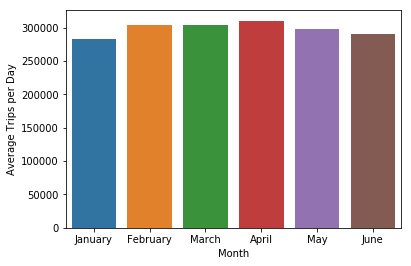

In [2]:
months = 'January February March April May June'.split()
df_new = pd.Series(index = months)
for i in range(6):
    string = "yellow_tripdata_2018-0"+str(i+1)+"_new.csv"
    df = pd.read_csv(string,usecols=["tpep_pickup_datetime"])
    df['day'] = pd.to_datetime(df["tpep_pickup_datetime"],format='%Y-%m-%d %H:%M:%S').dt.day
    df.dropna(inplace=True)
    df_new[months[i]] = len(df['day'])/(len(df['day'].unique()))
    del df
ax = sns.barplot(x=df_new.index, y=df_new.values)
ax.set(xlabel='Month', ylabel='Average Trips per Day')

In [ ]:
df_new

#### after this we plot the same graph for every Borough. 

[Text(0,0.5,'Average Daily Trips')]

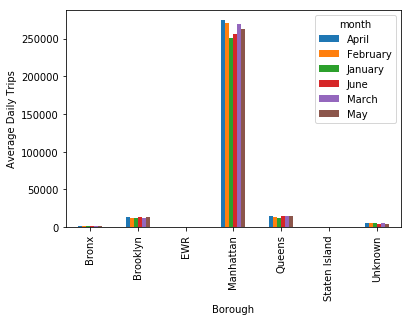

In [9]:
zones = pd.read_csv("taxi_zone_lookup.csv")
for i in range(6):
    string = "yellow_tripdata_2018-0"+str(i+1)+"_new.csv"
    df = pd.read_csv(string,usecols=["tpep_pickup_datetime","DOLocationID","month"])
    df['day'] = pd.to_datetime(df["tpep_pickup_datetime"],format='%Y-%m-%d %H:%M:%S').dt.day
    df = pd.merge(df,zones[['LocationID','Borough']], left_on=['DOLocationID'], right_on=['LocationID'])[['Borough','day','month']]
    df.dropna(inplace=True)
    df = df.groupby(['month','Borough']).count()['day']//(len(df['day'].unique()))
    if i>0:
        df_new = pd.concat([df_new,df],axis=1,keys='day')
        df_new.fillna(0,inplace=True)
        df_new = df_new.sum(axis=1)
    else:
        df_new = df
    del df
df_new.rename(index={1:'January',2:'February',3:'March',4:'April',5:'May',6:'June'},inplace=True)
ax = df_new.unstack(level=0).plot(kind='bar',subplots=False)
ax.set(ylabel='Average Daily Trips')

# RQ2 What are the time slots with more passengers?
#### Set your own time slots and discover which are those when Taxis drive the highest number of passengers overall New York and repeat the analysis for each borough. Provide the results through a visualization and comment them

In [14]:
time_slots = ['1.[1-6 AM]','2.[7-12 AM]','3.[13-18 PM]','4.[19-00 PM]']
df_total = pd.DataFrame([])
for month in range(6):
    string = "yellow_tripdata_2018-0"+str(month+1)+"_new.csv"
    df = pd.read_csv(string,usecols=['hour','DOLocationID','passenger_count'])
    df.dropna(inplace=True)
    df_total = df_total.append(df,ignore_index=True)
    del df
df_total = pd.merge(df_total,zones[['LocationID','Borough']], left_on=['DOLocationID'], right_on=['LocationID'])[['Borough','hour','passenger_count']]
df_total['time_slots'] = df_total.hour.apply(lambda x:time_slots[abs((x-1)//6)])

C:\Users\Daniele\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


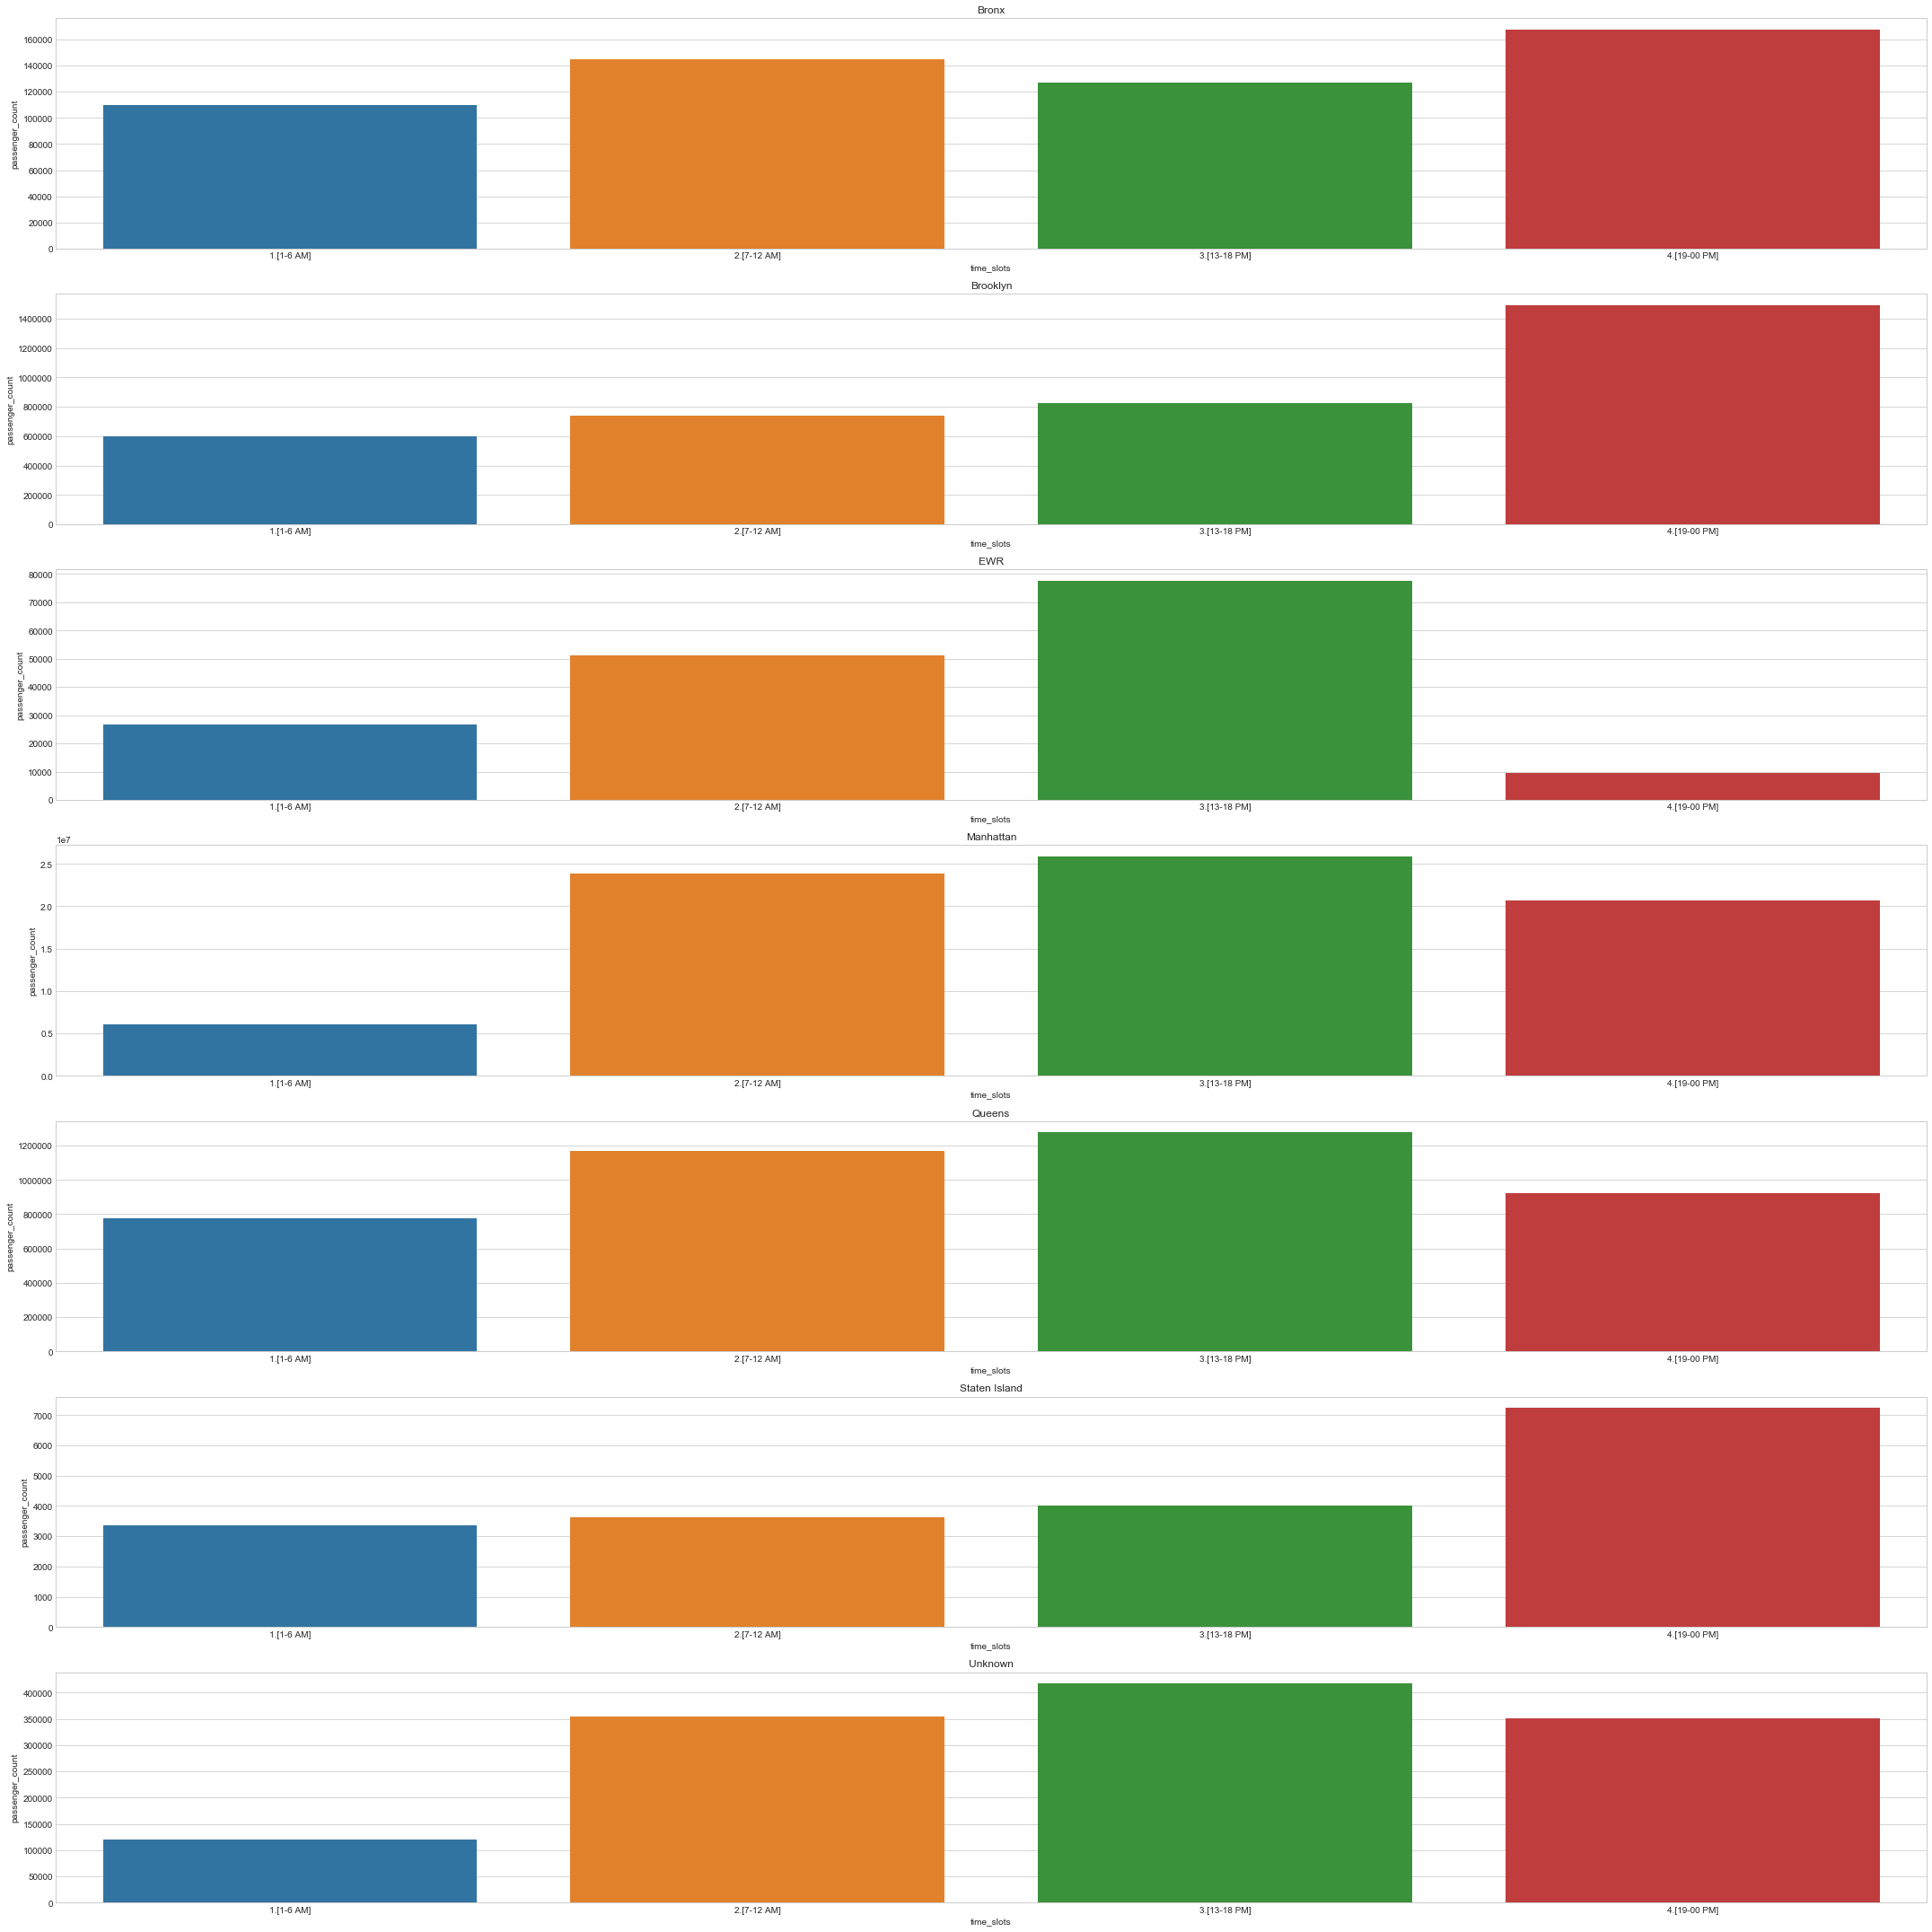

In [15]:
num_plots = 7
fig, axes = plt.subplots(num_plots,1,figsize=(30,30))
Boroughs = df_total.Borough.unique()
Boroughs.sort()
for Borough in Boroughs:
    df = df_total[df_total['Borough']==Borough]
    df=df.groupby('time_slots',as_index=False).sum()
    df.sort_values(by='time_slots',inplace=True)
    ax_curr = axes[np.where(Boroughs == Borough)[0][0]]
    sns.set_style("whitegrid")
    fg = sns.barplot(x=df.time_slots,y=df.passenger_count,ax=ax_curr)
    ax_curr.set_title(Borough)
    del df
fig.tight_layout()

C:\Users\Daniele\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5,1,'Overall New York')

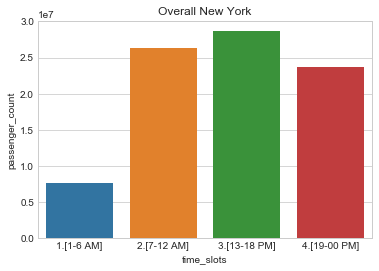

In [16]:
df_total=df_total.groupby('time_slots',as_index=False).sum()
df_total.sort_values(by='time_slots',inplace=True)
sns.set_style("whitegrid")
fig = sns.barplot(x=df_total.time_slots,y=df_total.passenger_count)
fig.set_title('Overall New York')

# RQ3 Do the all trips last the same? 
#### Let's put our attention on the distribution of trip's duration. Provide a plot for it and comment what you see. Run this analysis for NYC and for each borough (and obviously comment the results!).

# RQ4 What is the most common way of payments? 
#### Discover the way payments are executed in each borough and visualize the number of payments for any possible means. Then run the Chi-squared test to see whether the method of payment is correlated to the borough. Then, comment the results.

C:\Users\Daniele\Anaconda3\lib\site-packages\seaborn\categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


Text(0.5,1,'Distribution of payment type for every Borough')

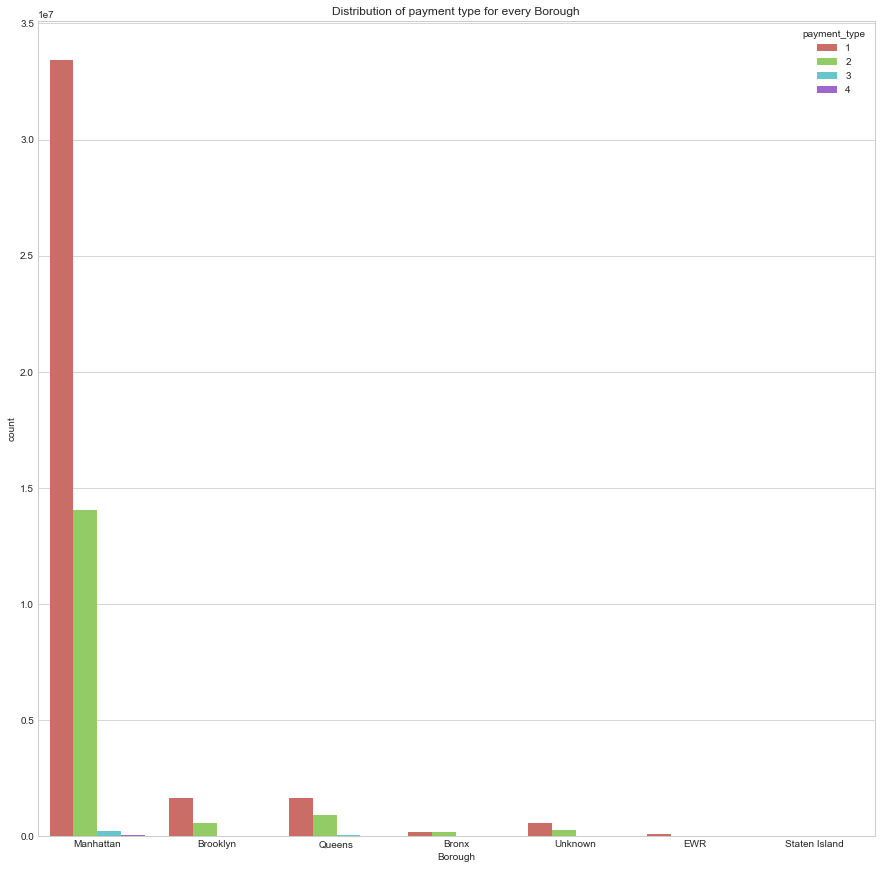

In [17]:
months = 'January February March April May June'.split()
df_total = pd.DataFrame([])
fig, axes = plt.subplots(1,1,figsize=(15,15))
for i in range(6):
    string = "yellow_tripdata_2018-0"+str(i+1)+"_new.csv"
    df = pd.read_csv(string)
    df = df[["DOLocationID","payment_type","month"]]
    df = pd.merge(df,zones[['LocationID','Borough']], left_on=['DOLocationID'], right_on=['LocationID'])[['Borough','payment_type','month']]
    df_total = df_total.append(df,ignore_index=True)
    del df
df_total['month'] = df_total['month'].apply(lambda x : months[x-1])
sns.set_style("whitegrid")
fg = sns.countplot(x='Borough', hue='payment_type', data=df_total,palette='hls')
fg.set_title('Distribution of payment type for every Borough')

In [18]:
manhattan_value = df_total.loc[df_total['Borough'] == 'Manhattan']['payment_type']
Bronx_value = df_total.loc[df_total['Borough'] == 'Bronx']['payment_type']
Brooklyn_value = df_total.loc[df_total['Borough'] == 'Brooklyn']['payment_type']
EWR_value = df_total.loc[df_total['Borough'] == 'EWR']['payment_type']
Queens_value = df_total.loc[df_total['Borough'] == 'Queens']['payment_type']
State_Island_value = df_total.loc[df_total['Borough'] == 'Staten Island']['payment_type']

In [21]:
chi_test=np.array([manhattan_value.value_counts().sort_index(axis=0),Bronx_value.value_counts().sort_index(axis=0),Brooklyn_value.value_counts().sort_index(axis=0),EWR_value.value_counts().sort_index(axis=0),Queens_value.value_counts().sort_index(axis=0),State_Island_value.value_counts().sort_index(axis=0)]).T
chi_test_2=pd.DataFrame(chi_test)
chi2_stat, p_val, dof, ex = stats.chi2_contingency(chi_test_2)
print("===Chi2 Stat===")
print(chi2_stat)
print("\n")
print("===Degrees of Freedom===")
print(dof)
print("\n")
print("===P-Value===")
print(p_val)
print("\n")
print("===Contingency Table===")
print(ex)

===Chi2 Stat===
189106.93237467718


===Degrees of Freedom===
15


===P-Value===
0.0


===Contingency Table===
[[3.32885465e+07 2.36328148e+05 1.58992168e+06 6.95248498e+04
  1.79870403e+06 7.84383278e+03]
 [1.41363309e+07 1.00359230e+05 6.75176941e+05 2.95244576e+04
  7.63838555e+05 3.33096597e+03]
 [2.47426450e+05 1.75657519e+03 1.18175385e+04 5.16762929e+02
  1.33693717e+04 5.83014853e+01]
 [6.74772412e+04 4.79046794e+02 3.22283609e+03 1.40929706e+02
  3.64604642e+03 1.58997689e+01]]


# RQ5 Does a long distance correlate with the duration of the trip on average?
#### Make a plot that show the dependence between distance and duration of the trip. Then compute the Pearson Coefficient, is it significant? Comment the results you obtain.

In [2]:
df_total = pd.DataFrame([])
for month in range(6):
    string = "yellow_tripdata_2018-0"+str(month+1)+"_new.csv"
    df = pd.read_csv(string,usecols=['tpep_pickup_datetime','tpep_dropoff_datetime','trip_distance'])
    df = df[df['trip_distance']>2]  ##take long distances
    df.dropna(inplace=True)
    df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
    df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
    df['trip_duration'] = (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"])
    df['trip_duration'] = pd.to_timedelta(df['trip_duration']).apply(lambda x:x.seconds/60)
    df_total = df_total.append(df[['trip_distance','trip_duration']],ignore_index=True)
    del df

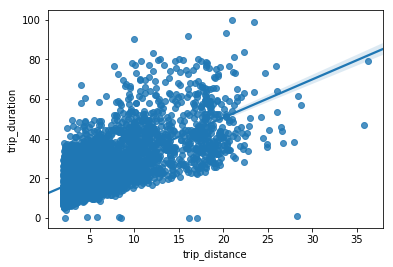

In [5]:
df1 = df_total[(df_total['trip_duration'] <= 100) & (df_total['trip_distance'] <= 40)]
ax = sns.regplot(x="trip_distance", y="trip_duration", data=df1.sample(5000))

In [6]:
correlation = df1.corr(method='pearson')
print(correlation)

               trip_distance  trip_duration
trip_distance       1.000000       0.721409
trip_duration       0.721409       1.000000


# CRQ1: Does the fare for mile change across NY's borough? 
## #We want to discover whether the expenses of a user that enjoys Taxis in one zone is different from those that uses it in another one.
#### 1)Considering the fare amount:
#### -Compute the price per mile equation for each trip.
#### -Run the mean and the standard deviation of the new variable for each borough. Then plot the distribution. What do you see?
#### -Run the t-test among all the possible pairs of distribution of different boroughs.
#### -Can you say that statistically significant differences, on the averages, hold among zones? In other words, are Taxis trip in some boroughs, on average, more expensive than others?
#### 2)The price per mile might depend on traffic the Taxi finds on its way. So we try to mitigate this effect:
#### -Likely, the duration of the trip says something about the city's congestion, especially if combined with the distances. It might be a good idea to weight the price for mile using the T time equation needed to complete the trip. Thus, instead of P equation, you can useP'=P/T equation, where T equation is the time needed to complete the trip.
#### -Run the mean and the standard deviation of the new variable for each borough. Then plot the distribution. What do you see?
#### -Run the t-test among all the possible pairs of new distribution of different boroughs.
#### -Can you say that statistically significant differences, on the averages, hold among zones? In other words, are Taxis trip in some boroughs, on average, more expensive than others?
#### -3)Compare the results obtained for the price per mile and the weighted price for mile. What do you think about that?

# CRQ2: Visualize Taxis movements! 
#### NYC is divided in many Taxis zones. For each yellow cab trip we know the zone the Taxi pick up and drop off the users. Let's visualize, on a chropleth map, the number of trips that starts in each zone. Than, do another map to count the races that end up in the single zone. Comment your discoveries

In [7]:
zones = pd.read_csv("taxi_zone_lookup.csv")
value_to_choropleth = pd.DataFrame([])
for i in range(6):
    string = "yellow_tripdata_2018-0"+str(i+1)+"_new.csv"
    df = pd.read_csv(string,usecols=["PULocationID","DOLocationID"])
    df.dropna(inplace=True)
    value_to_choropleth=value_to_choropleth.append(df,ignore_index=True)
    del df

#### Number of trips that starts in each zone

In [8]:
value_to_choropleth_start = pd.merge(value_to_choropleth,zones, left_on=['PULocationID'], right_on=['LocationID'])[['Zone','PULocationID']]
test=value_to_choropleth_start.groupby(['Zone'],as_index=False).count()
test.columns=['Zone','Counter']
value_to_choropleth_start2 = pd.merge(test,zones, left_on=['Zone'], right_on=['Zone'])

In [9]:
map_1 = folium.Map(location=[40.767937,-73.982155 ],tiles='OpenStreetMap',
 zoom_start=12)

In [12]:
with open('taxi_zones.json') as f:
    data = json.load(f)

In [14]:
map_1.choropleth(
    geo_data='taxi_zones.json',
    data=value_to_choropleth_start2,
    columns=['LocationID','Counter'],
    key_on='feature.properties.LocationID',
    fill_color='YlOrRd',
    legend_name='Taxi Counter',
    fill_opacity=0.7,
    line_opacity=0.2,
    threshold_scale = [20,200,2000,20000,200000,2000000]
    
)
map_1.save('GeoJSON_New_york_Start.html')

#### Number of trips that end in each zone

In [15]:
value_to_choropleth_end = pd.merge(value_to_choropleth,zones, left_on=['DOLocationID'], right_on=['LocationID'])[['Zone','DOLocationID']]
test1=value_to_choropleth_end.groupby(['Zone'],as_index=False).count()
test1.columns=['Zone','Counter']
value_to_choropleth_end2 = pd.merge(test1,zones, left_on=['Zone'], right_on=['Zone'])

In [16]:
map_1.choropleth(
    geo_data='taxi_zones.json',
    data=value_to_choropleth_end2,
    columns=['LocationID','Counter'],
    key_on='feature.properties.LocationID',
    fill_color='YlOrRd',
    legend_name='Taxi Counter',
    fill_opacity=0.7,
    line_opacity=0.2,
    threshold_scale = [20,200,2000,20000,200000,2000000]
    
)
map_1.save('GeoJSON_New_york_end.html')